## Post_Analysis2
- Dam classification by reservoir operation performances
- Hydrological Climate Classification (HCC) and Köppen-Geiger Climate Classification (KGC)

In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sns
from scipy import stats
import HydroErr as he
from tools import save_hdf
from itertools import compress
from functools import reduce
import warnings
warnings.filterwarnings('ignore',category=pd.io.pytables.PerformanceWarning)

In [2]:
# Load Dam Inflow data from SUTD
dfFlowDams = pd.read_hdf('./data/dfFlowDams.hdf')
ind_dams = np.load('./data/ind_dams.npz')['ind_dams']
# Load Degree of Regulation (DOR)
dor = pd.read_hdf('./data/new_dor.hdf')      # The order is sorted during the process
dam_dor = dor.loc[dor.DOR2 <= 0, 'GRAND_ID']
# Select only headwater dams (735)
idx_dor = np.isin(ind_dams[0,:], dam_dor)
damList = ind_dams[0,idx_dor]
ind_dams = ind_dams[1,idx_dor]
ndam = len(damList)
# KGE score at MP1
kge = pd.read_hdf('./data/subset.hdf', 'df').reset_index(drop=False)[['GRAND_ID','KGE_MP1']]
# Load hydropower production results
prod = pd.read_hdf('./data/hydropower_production.hdf').loc[damList].reset_index()[['GRAND_ID','PF','DF']]
# Dam characteristics
char = pd.read_csv('./data/res_obj_dor.csv')[['GRAND_ID','ECAP','MAIN_USE']].set_index('GRAND_ID').loc[damList].reset_index()
# Climate classifications and Continents and Countries
cclass = pd.read_hdf('./data/climate_classification.hdf').loc[damList].reset_index()

# Merge DataFrames
data_frames = [kge,prod,char,cclass]
data_basic = reduce(lambda  left,right: pd.merge(left,right,on=['GRAND_ID'],how='inner'), data_frames)
data_basic = data_basic.rename(columns={'KGE_MP1':'KGE'})
data_basic.head()

,GRAND_ID,KGE,PF,DF,ECAP,MAIN_USE,aridity,seasonality,snow,kgc1,kgc2,CONTINENT,COUNTRY
0,6,0.763066,1.247932,-2.864089,2730.0,Hydroelectricity,0.394127,0.727136,0.400318,Dfc,Dfc,North America,Canada
1,25,0.603888,6.642156,-5.942719,65.0,Hydroelectricity,0.093695,0.645148,0.272423,Cfc,Cfb,North America,Canada
2,27,0.606360,3.295483,0.321211,46.0,Hydroelectricity,0.188873,0.725226,0.335959,Cfb,Csb,North America,Canada
3,31,0.682417,3.726917,-9.344951,28.0,Hydroelectricity,0.099993,0.702323,0.000000,Cfb,Cfb,North America,Canada
4,35,0.423303,5.664064,-5.414288,9.0,Hydroelectricity,0.127858,0.624010,0.550539,Dfc,Dfb,North America,Canada


### Dam Classification
The regression is performed by Jia.

In [3]:
# Load regression variables
df_var = pd.read_hdf('./data/regression_variables.hdf').reset_index()
# Subset of required indicators
target_var = ['dep_over_head2', 'perc_qmax', 'fill_mean_mon']
subset = pd.merge(data_basic[['GRAND_ID','PF', 'DF', 'KGE']], df_var[['GRAND_ID', *target_var]], on='GRAND_ID', how='inner').set_index('GRAND_ID')
subset.columns = ['PF', 'DF', 'KGE', 'depth', 'qmax', 'fill']

# Threshold regressed by Jia
goodDam = subset['PF'] > 10
goodForecast = subset['KGE'] > 0.463
anyForecast = (subset['depth'] < 0.630) \
                | (subset['qmax'] > 0.293) \
                | (subset['fill'] < 0.255)

# Classification
type_a1 = goodDam & goodForecast & anyForecast
type_a2 = goodDam & goodForecast & ~anyForecast
type_b = ~goodDam & goodForecast
type_c1 = goodDam & ~goodForecast & anyForecast
type_c2 = goodDam & ~goodForecast & ~anyForecast
type_d = ~goodDam & ~goodForecast
print('='*45)
print('Number of dams in classifications')
print('-'*45)
print('AI:\t%d (%.1f%%)' % (sum(type_a1), sum(type_a1)/ndam*100))
print('AII:\t%d (%.1f%%)' % (sum(type_a2), sum(type_a2)/ndam*100))
print('B:\t%d (%.1f%%)' % (sum(type_b), sum(type_b)/ndam*100))
print('CI:\t%d (%.1f%%)' % (sum(type_c1), sum(type_c1)/ndam*100))
print('CII:\t%d (%.1f%%)' % (sum(type_c2), sum(type_c2)/ndam*100))
print('D:\t%d (%.1f%%)' % (sum(type_d), sum(type_d)/ndam*100))
print('Total:\t%d' % (sum(type_a1)+sum(type_a2)+sum(type_b)+sum(type_c1) \
                      + sum(type_c2) + sum(type_d)))
print('='*45)

# Improvements by classifcation
ClassName = ['AI','AII','B','CI','CII','D']
impv6D = pd.concat([subset[ind]['DF'] for ind in list((type_a1, type_a2, type_b, type_c1, type_c2, type_d))], axis=1)
impv6D.columns = ClassName
impv6P = pd.concat([subset[ind]['PF'] for ind in list((type_a1, type_a2, type_b, type_c1, type_c2, type_d))], axis=1)
impv6P.columns = ClassName

# Series of classification
DamClass = pd.Series(data=np.zeros([ndam]), 
                     index = type_a1.index, 
                     name='class')
DamClass[type_a1] = 1
DamClass[type_a2] = 2
DamClass[type_b] = 3
DamClass[type_c1] = 4
DamClass[type_c2] = 5
DamClass[type_d] = 6

Number of dams in classifications
---------------------------------------------
AI:	23 (3.1%)
AII:	33 (4.5%)
B:	567 (77.1%)
CI:	3 (0.4%)
CII:	7 (1.0%)
D:	102 (13.9%)
Total:	735


### Merge DataFrames

In [4]:
# Merge DataFrames
data_frames = [data_basic,DamClass]
data = reduce(lambda  left,right: pd.merge(left,right,on=['GRAND_ID'],how='inner'), data_frames)
data = data.rename(columns={'KGE_MP1':'KGE'})
# Save data
save_hdf('./data/data_analysis.hdf', data)
data.to_excel('./data/dam_climate_classification.xlsx')
data.head()

./data/data_analysis.hdf is saved.


,GRAND_ID,KGE,PF,DF,ECAP,MAIN_USE,aridity,seasonality,snow,kgc1,kgc2,CONTINENT,COUNTRY,class
0,6,0.763066,1.247932,-2.864089,2730.0,Hydroelectricity,0.394127,0.727136,0.400318,Dfc,Dfc,North America,Canada,3.0
1,25,0.603888,6.642156,-5.942719,65.0,Hydroelectricity,0.093695,0.645148,0.272423,Cfc,Cfb,North America,Canada,3.0
2,27,0.606360,3.295483,0.321211,46.0,Hydroelectricity,0.188873,0.725226,0.335959,Cfb,Csb,North America,Canada,3.0
3,31,0.682417,3.726917,-9.344951,28.0,Hydroelectricity,0.099993,0.702323,0.000000,Cfb,Cfb,North America,Canada,3.0
4,35,0.423303,5.664064,-5.414288,9.0,Hydroelectricity,0.127858,0.624010,0.550539,Dfc,Dfb,North America,Canada,6.0


### Scatter plot with HCC indices

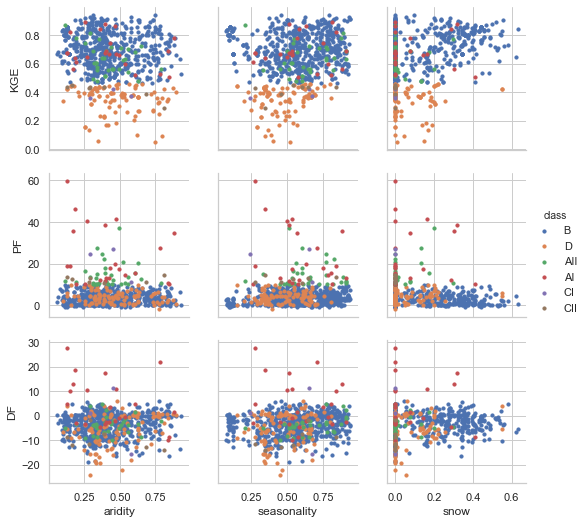

In [5]:
data2 = data.copy()
data2['class'] = data['class'].replace({1:'AI', 2:'AII', 3:'B', 4:'CI', 5:'CII', 6:'D'})
sns.set(rc={'figure.figsize':(6,6)})
sns.set_style("whitegrid")
# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,7))
g = sns.PairGrid(data2,
                 x_vars=["aridity", "seasonality", "snow"],
                 y_vars=["KGE", "PF", "DF"],
                 hue='class')
g = g.map(plt.scatter, s=10)
g = g.add_legend()
if False:
    fn_save = './figures/aggregation_hcc.png'
    g.savefig(fn_save, bbox_inches='tight')
    print('%s is saved.' % fn_save)

### ADD DAM CLASSIFICATION COLORS



### Boxplots of KGE, PF, DF according to KGC

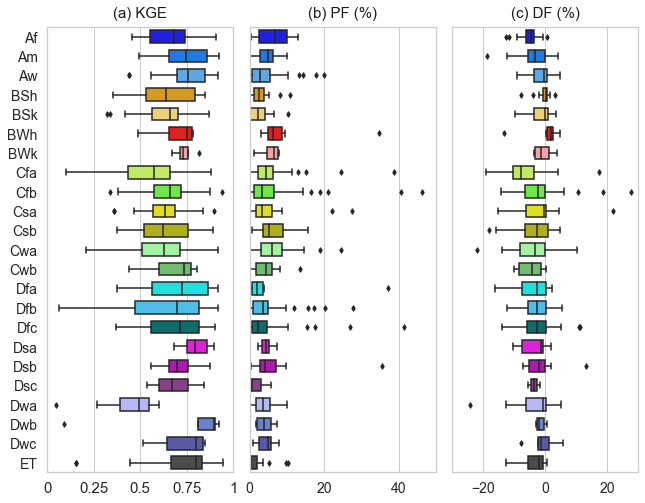

In [6]:
# KGC color scheme
code2 = pd.read_excel('./data/koppen_geiger_classification/code_rgb.xlsx').set_index('Code')
csch = code2.loc[np.unique(data['kgc2']), ['Red','Green','Blue']].values

# Figure setting
sns.set_style("whitegrid")
sns.set_palette(csch/255)
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(9,7), 
                         sharey=True, sharex=False,
                         gridspec_kw={'width_ratios':[1,1,1]})
# Plotting
name = ['(a) KGE', '(b) PF (%)', '(c) DF (%)']
for (i, el) in enumerate(['KGE', 'PF', 'DF']):
    ax = axes.flatten('F')[i]
    sns.boxplot(ax=ax, x=el, y='kgc2', data=data,
                order = np.unique(data['kgc2']),
                width=0.65, linewidth=1.5, fliersize=4)
    ax.set(xlabel="", ylabel="")
    ax.annotate(name[i], [0.5,1.03], xycoords='axes fraction',
                color='k', ha='center', va='center', fontfamily='sans-serif', fontsize=15)
    ax.xaxis.grid(True)
    ax.tick_params(axis='both', which='major', labelsize=14)
    if i == 0:
        ax.set_xlim([0, 1])
        ax.set_xticks(np.arange(0,1.1,0.25))
        ax.set_xticklabels(['0','0.25','0.5','0.75','1'], fontsize=15, fontname='arial')
    elif i == 1:
        ax.set_xlim([0, 50])
    elif i == 2:
        ax.set_xlim([-30, 30])
        ax.tick_params(axis='x', which='major')
fig.tight_layout(pad=0.7)
plt.show()

if False:
    fn_save = './figures/aggregation_kgc.pdf'
    fig.savefig(fn_save, bbox_inches='tight')
    print('%s is saved.' % fn_save)
    fn_save = './figures/aggregation_kgc.png'
    fig.savefig(fn_save, bbox_inches='tight')
    print('%s is saved.' % fn_save)

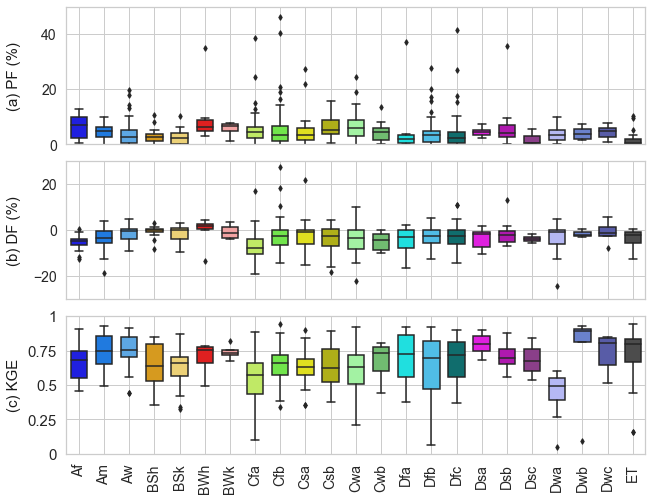

./figures/aggregation_kgc.pdf is saved.
./figures/aggregation_kgc.png is saved.


In [7]:
# KGC color scheme
code2 = pd.read_excel('./data/koppen_geiger_classification/code_rgb.xlsx').set_index('Code')
csch = code2.loc[np.unique(data['kgc2']), ['Red','Green','Blue']].values

# Figure setting
sns.set_style("whitegrid")
sns.set_palette(csch/255)
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(9,7), 
                         sharex=True, sharey=False,
                         gridspec_kw={'height_ratios':[1,1,1]})
# Plotting
name = ['(a) PF (%)', '(b) DF (%)', '(c) KGE']
for (i, el) in enumerate(['PF', 'DF', 'KGE']):
    ax = axes.flatten('F')[i]
    sns.boxplot(ax=ax, x='kgc2', y=el, data=data,
                order = np.unique(data['kgc2']),
                width=0.65, linewidth=1.5, fliersize=4)
    ax.set(xlabel="", ylabel="")
    ax.annotate(name[i], [-0.09,0.5], xycoords='axes fraction', rotation=90,
                color='k', ha='center', va='center', fontfamily='sans-serif', fontsize=15)
    ax.xaxis.grid(True)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=14, fontname='arial', rotation=90)
    if el == 'KGE':
        ax.set_ylim([0, 1])
        ax.set_yticks(np.arange(0,1.1,0.25))
        ax.set_yticklabels(['0','0.25','0.5','0.75','1'], fontsize=15, fontname='arial')
    elif el == 'PF':
        ax.set_ylim([0, 50])
    elif el == 'DF':
        ax.set_ylim([-30, 30])
        ax.tick_params(axis='y', which='major')
fig.tight_layout(pad=0.7)
plt.show()

if True:
    fn_save = './figures/aggregation_kgc.pdf'
    fig.savefig(fn_save, bbox_inches='tight')
    print('%s is saved.' % fn_save)
    fn_save = './figures/aggregation_kgc.png'
    fig.savefig(fn_save, bbox_inches='tight')
    print('%s is saved.' % fn_save)

In [8]:
data['I'] = data['DF']/data['PF']

In [9]:
data['I'].max()

184.32573036726967

### Aggregation by continents

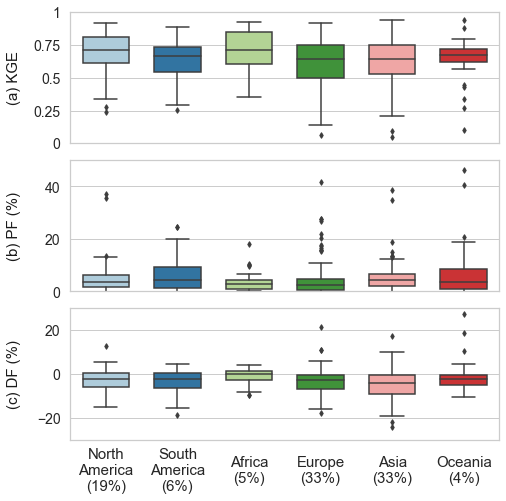

./figures/aggregation_continent.pdf is saved.
./figures/aggregation_continent.png is saved.


In [10]:
sns.set_style('whitegrid')
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(7,7), 
                         sharey=False, sharex=True,
                         gridspec_kw={'height_ratios':[1,1,1]},
                         facecolor='w')
# Plotting
name = ['(a) KGE', '(b) PF (%)', '(c) DF (%)']
cont_order = ['North America', 'South America', 'Africa','Europe', 'Asia', 'Oceania']
cont_name = ['North\nAmerica', 'South\nAmerica', 'Africa','Europe', 'Asia', 'Oceania']
prct_dam = np.round(data.groupby('CONTINENT')['COUNTRY'].count()/ndam*100)[cont_order]
cont_name = ['%s\n(%d%%)' % (cname,cprct) for cname, cprct in zip(cont_name, list(prct_dam))]


for (i, el) in enumerate(['KGE', 'PF', 'DF']):
    ax = axes.flatten('F')[i]
    sns.boxplot(ax=ax, x='CONTINENT', y=el, data=data,
                order = cont_order, palette = 'Paired',
                width=0.65, linewidth=1.5, fliersize=4)
    ax.set(xlabel="", ylabel="")
    ax.annotate(name[i], [-0.13, 0.5], 
                rotation=90, xycoords='axes fraction',
                color='k', ha='center', va='center', fontfamily='sans-serif', fontsize=15)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.yaxis.grid(True)
    if i == 0:
        ax.set_ylim([0, 1])
        ax.set_yticks(np.arange(0,1.1,0.25))
        ax.set_yticklabels(['0','0.25','0.5','0.75','1'], fontsize=14, fontname='sans-serif')
    elif i == 1:
        ax.set_ylim([0, 50])
    elif i == 2:
        ax.set_ylim([-30, 30])
        ax.set_xticklabels(cont_name, fontfamily='sans-serif', fontsize=15, va='center')
        ax.tick_params(axis='x', which='major', pad=25)

# Finalizing
fig.tight_layout(pad=0.7)
plt.show()
fn_save = './figures/aggregation_continent.pdf'
fig.savefig(fn_save, bbox_inches='tight')
print('%s is saved.' % fn_save)
fn_save = './figures/aggregation_continent.png'
fig.savefig(fn_save, bbox_inches='tight')
print('%s is saved.' % fn_save)

In [11]:
### Update figure
# 1) Merge PF and DF
# 2) At the third row, 6 boxplots representing 6 classes per each continent

In [12]:
data2['class'] = data['class'].replace({1:'AI', 2:'AII', 3:'B', 4:'CI', 5:'CII', 6:'D'})
data2[['CONTINENT', 'class']].groupby('CONTINENT').value_count()

AttributeError: 'DataFrameGroupBy' object has no attribute 'value_count'

### Dam classification scatter plot

In [ ]:
temp = data[['GRAND_ID','PF','DF','KGE']]
temp = temp.merge(DamClass.reset_index(), on='GRAND_ID', how='inner')

# Colormap
colorsList = ['lightcoral','crimson', 
              'gold', 
              'lightgreen', 'green',
              'cornflowerblue']
cmap = colors.ListedColormap(colorsList)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8.5,7.5), 
                         sharey=True, sharex=False,
                         gridspec_kw={'width_ratios':[1.8,1]})

# (a) Scatterplot of PF and wKGE
ax = axes.flatten('C')[0]
sc = sns.scatterplot(data=temp, x='KGE', y='PF', ax=ax, marker='o', 
                     linewidth=0.5, alpha=0.5, palette=cmap,
                     hue='class', hue_norm=(1, 6))
ax.plot([-1, 1], [10, 10], color='grey', lw=1, alpha=0.5, linestyle='--')
ax.plot([0.463, 0.463], [-100, 100], color='grey', lw=1, alpha=0.5, linestyle='--')
ax.get_legend().remove()
sc.tick_params(labelsize=13)
ax.yaxis.set_tick_params(which='both', labelbottom=True)
ax.set_xticklabels([])
ax.set_xlabel('')
ax.set_yticks(np.arange(-20,65,10))
ax.set_ylabel(r'$I_{PF}$ (%)', fontsize=15, fontname='arial')
ax.set_xlim([-0.1, 1])
ax.set_ylim([-20, 65])
ax.annotate('(a)', xy=(0.06, 0.92), xycoords='axes fraction',
            horizontalalignment='center', verticalalignment='center',
            fontname='arial',fontsize=20)
# (b) Boxplot of PF and classifications
ax = axes.flatten('C')[1]
sc = sns.boxplot(data=impv6P, ax=ax, width=0.7, palette=colorsList)
sc.plot([-10, 10], [10, 10], color='grey', lw=1, alpha=0.5, linestyle='--')
sc.tick_params(labelsize=13)
sc.set_xlim([-0.7, 5.7])
ax.set_xticklabels([])
ax.annotate('(b)', xy=(0.90, 0.92), xycoords='axes fraction',
            horizontalalignment='center', verticalalignment='center',
            fontname='arial',fontsize=20)
# (c) Scatterplot of PF and wKGE
ax = axes.flatten('C')[2]
sc = sns.scatterplot(data=temp, x='KGE', y='DF', ax=ax, marker='o', 
                     linewidth=0.5, alpha=0.5, palette=cmap, 
                     hue='class', hue_norm=(1, 6))
sc.tick_params(labelsize=12)
ax.set_xlim([-0.1, 1])
ax.plot([-1, 1], [10, 10], color='gray', lw=1, alpha=0.5, linestyle='--')
ax.plot([0.463, 0.463], [-100, 100], color='gray', lw=1, alpha=0.5, linestyle='--')
ax.get_legend().remove()
ax.tick_params(labelsize=13)
ax.set_ylabel(r'$I_{DF}$ (%)', fontsize=15, fontname='arial')
ax.set_xlim([-0.1, 1])
ax.set_ylim([-20, 65])
ax.set_xlabel('KGE', fontname='arial', fontsize=15,
              horizontalalignment='center', labelpad = 13)
ax.annotate('(c)', xy=(0.06, 0.92), xycoords='axes fraction',
            horizontalalignment='center', verticalalignment='center',
            fontname='arial',fontsize=20)
# (d) Boxplot of PF and classifications
ax = axes.flatten('C')[3]
sc = sns.boxplot(data=impv6D, ax=ax, width=0.7, palette=colorsList)
sc.plot([-10, 10], [10, 10], color='gray', lw=1, alpha=0.5, linestyle='--')
ax.set_xlabel('Types', fontname='arial', fontsize=15,
             horizontalalignment='center', labelpad = 13)
sc.tick_params(labelsize=13)
sc.set_xlim([-0.7, 5.7])
ax.annotate('(d)', xy=(0.90, 0.92), xycoords='axes fraction',
            horizontalalignment='center', verticalalignment='center',
            fontname='arial',fontsize=20)

plt.tight_layout(w_pad=0.02, h_pad=0.1)
plt.show()
# Save a figure
if False:
    fn_save = './figures/impv_classification.png'
    fig.savefig(fn_save, bbox_inches='tight')
    print('%s is saved.' % fn_save)